In [2]:
import torch
from torch import nn
from tqdm import tqdm
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import torchmetrics
from torch.utils import data
from torchvision.transforms import v2
import numpy as np
import os
from matplotlib import pyplot as plt
from torch.nn import functional as F

from pathlib import Path

In [3]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "num_workers": 5,
    "epochs": 100,

    "checkpoint_dir": "~/ml/models/badapple_in_nn",
    "checkpoint_filename": "badapple_in_nn-{epoch:02d}-{valid_acc:.2f}",
    "onnx_path": "~/ml/models/badapple_in_nn/badapple_in_nn.onnx",

    "log_dir": "~/ml/logs/badapple_in_nn",
    "log_name": "bad_apple_nn",

    "badapple_video": "./assets/Bad Apple.mp4",
    "badapple_frames": "./assets/frames",
    "display_size": (360//3, 480//3),
    "interpreter_layers": 10,
}

def replace_home():
    global config
    home_dir = Path.home()

    for key, value in config.items():
        if isinstance(value, str):
            config[key] = value.replace("~", str(home_dir.absolute()))

replace_home()

images.dtype=torch.float32
labels.dtype=torch.int64
images.shape=torch.Size([9, 1, 81, 81])
images[0].view(-1).max(dim=0).values=tensor(1.)
images[0].view(-1).min(dim=0).values=tensor(0.)
images[0]=tensor([[[0.0000e+00, 1.1921e-07, 5.9605e-08, 0.0000e+00, 5.9605e-08,
          0.0000e+00, 5.9605e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          5.9605e-08, 5.9605e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          5.9605e-08, 5.9605e-08, 0.0000e+00, 0.0000e+00, 5.9605e-08,
          0.0000e+00, 5.9605e-08, 5.9605e-08, 0.0000e+00, 0.0000e+00,
          1.7881e-07, 5.9605e-08, 1.7881e-07, 0.0000e+00, 0.0000e+00,
          1.7881e-07, 0.0000e+00, 0.0000e+00, 1.7881e-07, 5.9605e-08,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00

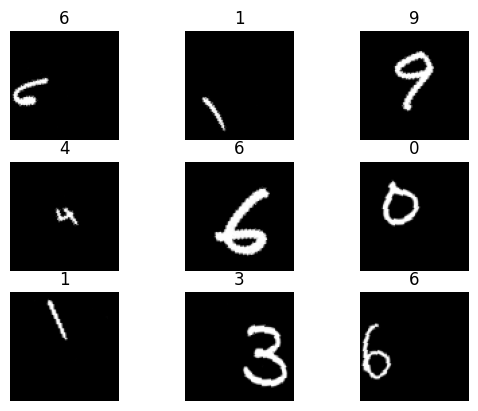

In [4]:
class HWDPlus(data.Dataset):
    def __init__(self, image_file, writer_info_file, transforms=None):
        self.images = np.expand_dims(np.load(image_file), axis=-1)
        self.writer_info = np.load(writer_info_file).astype(np.int64)
        self.labels = self.writer_info[:, 0]
        self.transforms = transforms

        self.len = self.images.shape[0]

    def __getitem__(self, index):
        if self.transforms is not None:
            image = self.transforms(self.images[index])
        else:
            image = self.images[index]
        return image, self.labels[index]

    def __len__(self):
        return self.len

def get_loaders(batch_size=32):
    transforms = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.RandomZoomOut(1, (1, 2)),
        v2.Resize((81, 81), antialias=True),
        v2.Lambda(lambda x: (-x + 1).clip(0, 1)),
        v2.RandomRotation(30, fill=0),
        v2.RandomAffine(0, translate=(0.3, 0.2)),
        #v2.Lambda(lambda x: (x + torch.rand_like(x) * 0.2).clamp(-1, 1)),
    ])

    dataset = HWDPlus(
        # https://link.springer.com/article/10.1007/s42979-022-01494-2#article-info
        # https://drive.google.com/drive/folders/1f2o1kjXLvcxRgtmMMuDkA2PQ5Zato4Or
        "/home/kanna/ml/datasets/Images(500x500)-001.npy",
        "/home/kanna/ml/datasets/WriterInfo.npy",
        transforms,
    )

    train, val = data.random_split(dataset, [11_000, 2_580])

    train_loader = data.DataLoader(
        train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config["num_workers"],
        pin_memory=True,
    )

    val_loader = data.DataLoader(
        val,
        batch_size=batch_size,
        num_workers=config["num_workers"],
        pin_memory=True
    )

    return train_loader, val_loader


def test():
    train_loader, val_loader = get_loaders(9)

    images, labels = next(iter(train_loader))
    
    print(f"{images.dtype=}")
    print(f"{labels.dtype=}")

    print(f"{images.shape=}")
    print(f"{images[0].view(-1).max(dim=0).values=}")
    print(f"{images[0].view(-1).min(dim=0).values=}")
    torch.set_printoptions(profile="full")
    print(f"{images[0]=}")

    assert len(images) == 9, f"{len(image)} should be 9"
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(3, 3, i + 1)
        plt.axis("off")
        plt.title(label.item())
        plt.imshow(image.reshape(81, 81), cmap="gray")


test()

In [4]:

import cv2 
from PIL import Image

def convert(vidfile, startms, idoffset):
    frames = []

    cam = cv2.VideoCapture(vidfile)
    fps = cam.get(cv2.CAP_PROP_FPS)
    ms_per_frame = 1000 / fps

    cam.set(cv2.CAP_PROP_POS_MSEC, startms + idoffset * ms_per_frame)

    pos_after_offset = int(cam.get(cv2.CAP_PROP_POS_FRAMES))
    total_frames = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) - pos_after_offset

    print('Extracting Frames...')
    with tqdm(total=total_frames) as progress:
        while True:
            frame_num = int(cam.get(cv2.CAP_PROP_POS_FRAMES)) - pos_after_offset
            progress.update(1)

            ret, frame = cam.read()
            if not ret: break
            frames.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)))

    cam.release()

    print(f"{ms_per_frame=}")

    return frames

frames = convert(config["badapple_video"], 0, 0)

Extracting Frames...


6573it [00:04, 1619.84it/s]                          

ms_per_frame=33.333333333333336


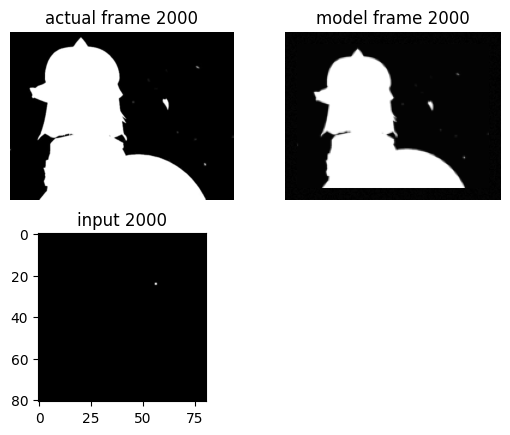

In [5]:
class LinearLayer(nn.Module):
    def __init__(self, input_size: int, output_size: int, bias=False):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size, bias=bias)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.linear(x))

class BadAppleInNN(L.LightningModule):
    def __init__(
            self, 
            input_size: int, 
            badapple_display_size: tuple[int, int], 
            interpreter_layers: int,
            frames,
    ):
        super().__init__()

        self.input_size = input_size**2
        self.badapple_display_size = badapple_display_size
        self.interpreter_layers = interpreter_layers

        self.display_width, self.display_height = badapple_display_size
        """
        # = interpreter_layers
        the inner box = display used for playing badapple

        ########################
        #|--------------------|#
        #|                    |# 
        #| bad apple display  |#
        #|                    |#
        #|--------------------|#
        ########################
        """
        self.full_display_width = self.display_width + 2 * self.interpreter_layers
        self.full_display_height = self.display_height + 2 * self.interpreter_layers
        self.full_display_size = self.full_display_width * self.full_display_height
        self.input_to_display = nn.Linear(self.input_size, self.full_display_size, bias=False)

        self.hidden_layers = nn.Sequential(
            LinearLayer(self.full_display_size, 512),
            LinearLayer(512, 256),
            LinearLayer(256, 128),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )

        self.embed_badapple(frames)

        # training stuff
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss = nn.NLLLoss().to(device)
        self.train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)

    def embed_badapple(self, frames):
        self.transforms = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize(self.badapple_display_size, antialias=True),
        ])

        display_model = zip(
            frames,
            # cuts out the interpreter layers
            self.input_to_display.weight
                .transpose(0, 1)
                .view(self.input_size, self.full_display_width, self.full_display_height)
                [:, self.interpreter_layers:self.full_display_width - self.interpreter_layers, self.interpreter_layers:self.full_display_height - self.interpreter_layers]
        )

        for frame, input_pixel in display_model:
            image = self.transforms(frame).squeeze(0)
            # print(image)
            # print(input_pixel.data.shape)
            # print(image.view(-1).shape)
            input_pixel.data[:, :] = image

        (
            next(self.hidden_layers.children()).linear
                .weight
                .view(512, self.full_display_width, self.full_display_height)
                .data
                [:, self.interpreter_layers:self.full_display_width - self.interpreter_layers, self.interpreter_layers:self.full_display_height - self.interpreter_layers]
        ) = torch.zeros(self.badapple_display_size)
        

    def forward(self, x):
        x = x.view(-1, 81**2)
        x = self.input_to_display(x)
        x = self.hidden_layers(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        self.log("train_loss", loss)
        self.train_acc(y_hat, y)
        self.log("train_acc", self.train_acc)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        self.valid_acc(y_hat, y)
        self.log("valid_acc", self.valid_acc)

    def on_before_optimizer_step(self, optimizer):
        # clear the badapple display gradients
        (
            next(self.input_to_display.parameters())
                .grad
                .transpose(0, 1)
                .view(self.input_size, self.full_display_width, self.full_display_height)
                [:, self.interpreter_layers:self.full_display_width - self.interpreter_layers, self.interpreter_layers:self.full_display_height - self.interpreter_layers]
        ) = torch.zeros(self.badapple_display_size)

        (
            next(self.hidden_layers.parameters())
                .grad
                .view(512, self.full_display_width, self.full_display_height)
                [:, self.interpreter_layers:self.full_display_width - self.interpreter_layers, self.interpreter_layers:self.full_display_height - self.interpreter_layers]
        ) = torch.zeros(self.badapple_display_size)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=config["learning_rate"], )

def test_model():
    test_frame_number = 2000
    display_size = config["display_size"]
    interpreter_layers = 10

    plt.subplot(2, 2, 1)
    plt.axis("off")
    plt.title(f"actual frame {test_frame_number}")
    plt.imshow(frames[test_frame_number], cmap="gray")

    model = BadAppleInNN(
        input_size=81,
        badapple_display_size=display_size,
        interpreter_layers=interpreter_layers,
        frames=frames,
    )
    
    with torch.no_grad():
        test_input = torch.zeros(1, 81**2)
        test_input[0][test_frame_number] = 1
        out = model.input_to_display(test_input)

    total_display_size = (display_size[0] + 2 * interpreter_layers, display_size[1] + 2 * interpreter_layers)

    plt.subplot(2, 2, 2)
    plt.axis("off")
    plt.title(f"model frame {test_frame_number}")
    plt.imshow(out[0].reshape(*total_display_size), cmap="gray")

    plt.subplot(2, 2, 3)
    plt.title(f"input {test_frame_number}")
    plt.imshow(test_input[0].reshape(81, 81), cmap="gray")


test_model()

In [57]:
def main():
    global model, logger
    model = BadAppleInNN(
        input_size=81,
        badapple_display_size=config["display_size"],
        interpreter_layers=config["interpreter_layers"],
        frames=frames,
    )

    train_loader, val_loader = get_loaders()

    logger = TensorBoardLogger(
        save_dir=config["log_dir"],
        name=config["log_name"],
    )

    checkpoints = ModelCheckpoint(
        dirpath=config["checkpoint_dir"],
        filename=config["checkpoint_filename"],
        monitor="valid_acc",
        mode="max",
        save_top_k=1,
    )

    trainer = L.Trainer(
        max_epochs=config["epochs"],
        logger=logger,
        accelerator="gpu",
        devices=1,
        callbacks=[checkpoints],
        precision="16-mixed",
        #profiler="simple",
    )

    trainer.fit(model, train_loader, val_loader)

main()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kanna/.conda/envs/torch/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /home/kanna/ml/models/badapple_in_nn exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params
--------------------------------------------------------
0 | input_to_display | Linear             | 165 M 
1 | hidden_layers    | Sequential         | 13.1 M
2 | classifier       | Sequential         | 1.3 K 
3 | transforms       | Compose            | 0     
4 | loss             | NLLLoss            | 0     
5 | train_acc        | MulticlassAccuracy | 0     
6 | valid_acc        | MulticlassAccuracy | 0     
--------------------------------------------------------
178 M     Trainable params
0         Non-tra

Epoch 99: 100%|██████████| 344/344 [01:09<00:00,  4.96it/s, v_num=5]       

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 344/344 [01:09<00:00,  4.96it/s, v_num=5]


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=/home/kanna/ml/logs/badapple_in_nn

In [6]:
def load_model():
    global model
    model = BadAppleInNN.load_from_checkpoint(
        checkpoint_path="/home/kanna/ml/models/badapple_in_nn/badapple_in_nn-epoch=86-valid_acc=0.61.ckpt",
        input_size=81,
        badapple_display_size=config["display_size"],
        interpreter_layers=config["interpreter_layers"],
        frames=frames,
    ).cpu()
load_model()

In [10]:
model.embed_badapple(frames)

tensor([[ -5.4074,  -3.1345,  -2.6930,  -5.1474,  -1.5366,  -2.5299,  -0.6521,
          -4.9773,  -3.0365,  -4.8416],
        [-10.1086,  -8.5862,  -7.3803,  -7.8564,  -0.0403,  -3.8912,  -5.7697,
          -6.8468,  -6.7778,  -4.3788],
        [ -1.7329,  -9.5819,  -6.0327,  -3.8273,  -7.5670,  -3.0550,  -3.8493,
          -5.5886,  -0.3256,  -5.4746],
        [ -5.0978,  -0.0582,  -6.8784,  -5.4569,  -6.3507,  -4.7535,  -4.9223,
          -5.2473,  -3.8849,  -6.3672],
        [ -3.7774,  -8.1789,  -4.7144,  -5.1617,  -5.1161,  -2.2965,  -0.4062,
          -7.5226,  -1.6721,  -6.9450],
        [ -3.3392,  -1.4014,  -1.5723,  -2.4360,  -3.6437,  -2.3825,  -2.0264,
          -2.3545,  -2.8447,  -3.9209],
        [-10.2313,  -8.4091,  -1.5956,  -6.8640,  -7.7500,  -5.7271,  -8.2679,
          -0.2343,  -8.9918,  -7.2061],
        [ -3.7797,  -5.8367,  -4.8916,  -1.0298,  -5.8390,  -0.8956,  -3.9981,
          -4.6200,  -1.9727,  -3.4703],
        [ -5.5497,  -9.7007,  -6.7088,  -0.4078,

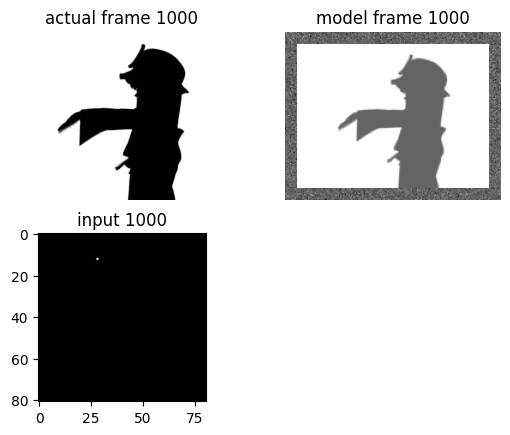

<Figure size 640x480 with 0 Axes>

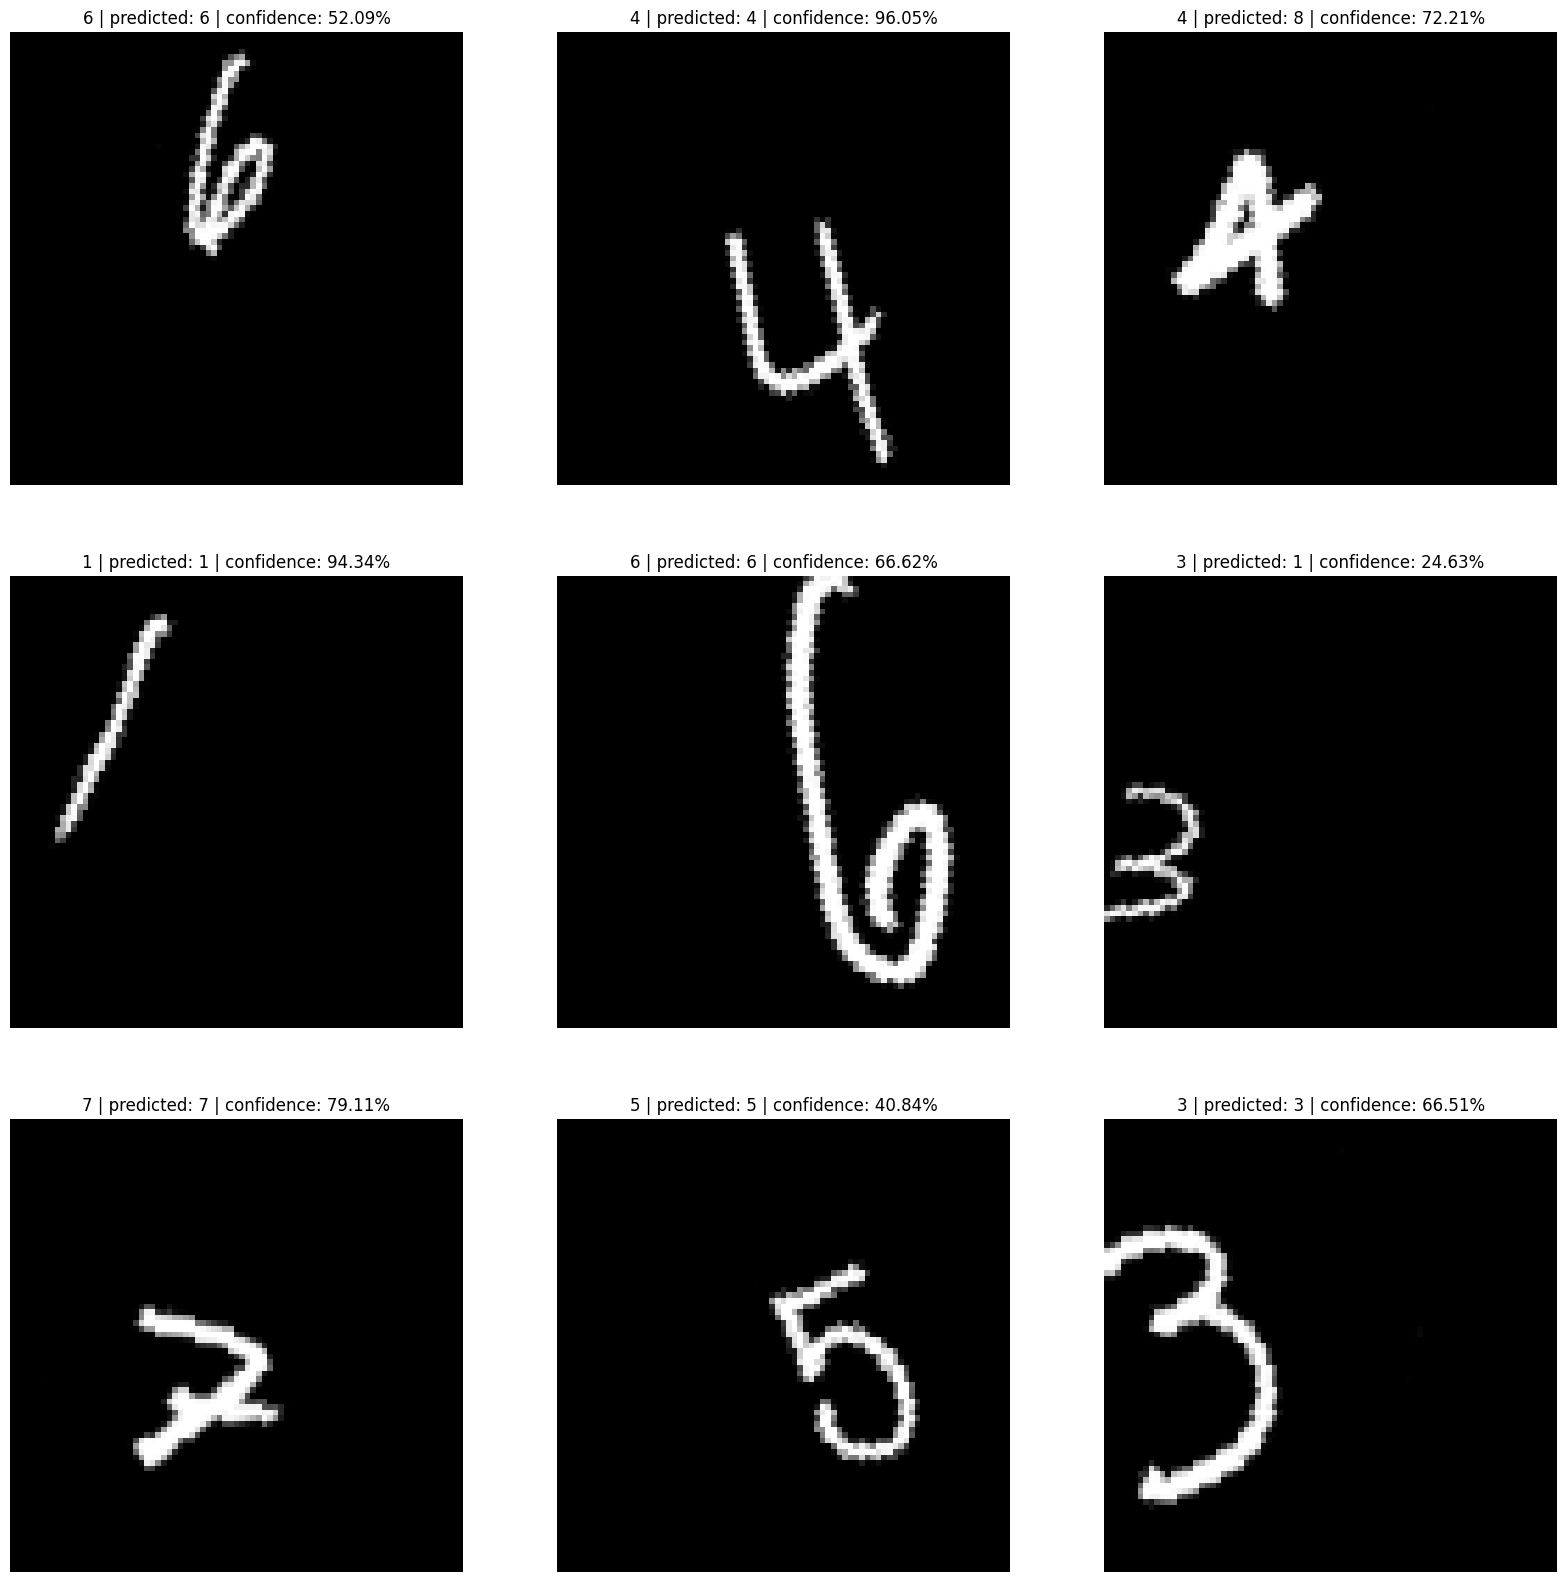

In [11]:
def test_model():
    global model
    test_frame_number = 1000
    display_size = config["display_size"]
    interpreter_layers = config["interpreter_layers"]

    plt.subplot(2, 2, 1)
    plt.axis("off")
    plt.title(f"actual frame {test_frame_number}")
    plt.imshow(frames[test_frame_number], cmap="gray")
    
    with torch.no_grad():
        test_input = torch.zeros(1, 81**2)
        test_input[0][test_frame_number] = 1
        out = model.input_to_display(test_input)

    total_display_size = (display_size[0] + 2 * interpreter_layers, display_size[1] + 2 * interpreter_layers)

    plt.subplot(2, 2, 2)
    plt.axis("off")
    plt.title(f"model frame {test_frame_number}")
    plt.imshow(out[0].reshape(*total_display_size), cmap="gray")

    plt.subplot(2, 2, 3)
    plt.title(f"input {test_frame_number}")
    plt.imshow(test_input[0].reshape(81, 81), cmap="gray")

    plt.figure()

    # test accuracy
    _, val_loader = get_loaders(9)
    images, labels = next(iter(val_loader))

    out = model(images)

    print(out)
    
    plt.figure(figsize=(20, 20))
    confidences = out.softmax(dim=1).max(dim=1).values
    predictions = out.argmax(dim=1)
    
    for i, (image, label, prediction, confidence) in enumerate(zip(images, labels, predictions, confidences)):
        plt.subplot(3, 3, i + 1)
        plt.axis("off")
        plt.title(f"{label.item()} | predicted: {prediction.item()} | confidence: {confidence.item():.2%}")
        plt.imshow(image.reshape(81, 81), cmap="gray")


test_model()

In [12]:
torch.set_printoptions(profile="default") # do not change to full (it uses a lot of memory)
model.input_to_display.weight

Parameter containing:
tensor([[ 0.1464,  0.0915,  0.0752,  ..., -0.2786, -0.3615, -0.4208],
        [-0.2932, -0.2496, -0.1608,  ..., -0.1072, -0.2240, -0.1735],
        [-0.0615,  0.0419,  0.0907,  ..., -0.0051, -0.0445, -0.0818],
        ...,
        [ 0.1886,  0.1483,  0.1031,  ...,  0.2433,  0.3455,  0.3783],
        [ 0.1487,  0.0874,  0.1093,  ...,  0.2321,  0.1887,  0.1283],
        [-0.1336, -0.0669, -0.0126,  ..., -0.2491, -0.2211, -0.1570]],
       requires_grad=True)

In [7]:
import gradio as gr

def launch_gradio():
    transforms = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((81, 81), antialias=True),
    ])

    def recognize_digit(image):
        with torch.no_grad():
            print(f"{image.keys()=}")
            image = transforms(np.expand_dims(image["composite"], axis=2))
            predictions = model(image).squeeze(dim=0).softmax(dim=0)
            return {str(i): prediction.item() for i, prediction in enumerate(predictions)}

    brush = gr.Brush(
        default_size=10,
        default_color="#FFFFFF",
        #colors=["#000000", "#FFFFFF"],
        color_mode="fixed",
    )

    # "https://zbase-global.zingfront.com/saasbox/resources/webp/loli4-1__3e4832ae6981121b935bfcb3db599b68.webp"
    sketchpad = gr.Sketchpad(brush=brush, image_mode="L")
    output_component = gr.Textbox()

    gr.Interface(fn=recognize_digit, 
                inputs=sketchpad, 
                outputs="label",
                title="MNIST Sketchpad",
                description="Draw a number 0 through 9 on the sketchpad, and click submit to see the model's predictions. Model trained on the MNIST dataset.",
                thumbnail="https://raw.githubusercontent.com/gradio-app/real-time-mnist/master/thumbnail2.png").launch()

launch_gradio()

/home/kanna/.conda/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


image.keys()=dict_keys(['background', 'layers', 'composite'])


In [8]:
def export_model():
    dynamic_axes = {'input' : {0 : 'batch_size'}, 
                            'output' : {0 : 'batch_size'}}
    torch.onnx.export(
        model=model, 
        args=torch.zeros(1, 81, 81), 
        f=config["onnx_path"],
        dynamic_axes=dynamic_axes,
        input_names=["input"],
        output_names=["output"],
    )
export_model()